In [12]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Dict, List, Tuple

from scipy.optimize import least_squares
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

In [13]:
def excel_serial_to_datetime(serial: pd.Series) -> pd.Series:
    return pd.to_datetime("1899-12-30") + pd.to_timedelta(serial, unit="D")


def load_bloomberg_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.columns = ["date", "ticker", "price"]

    df["ticker"] = df["ticker"].astype(str).str.strip()
    df["price"] = pd.to_numeric(df["price"], errors="coerce")

    s = df["date"].astype(str)

    # Dates buguées: "1970-01-01 00:00:00.000XXXXX" -> XXXXX = Excel serial day
    excel_pattern = r"^1970-01-01\s+00:00:00\.0*(\d+)$"
    serial_str = s.str.extract(excel_pattern, expand=False)
    serial = pd.to_numeric(serial_str, errors="coerce")
    excel_dates = excel_serial_to_datetime(serial)

    # Dates normales (2004-10-25, etc.)
    normal_dates = pd.to_datetime(s, format="mixed", errors="coerce")

    is_excel_date = serial.notna()
    df["date"] = normal_dates.where(~is_excel_date, excel_dates)

    df = df.dropna(subset=["date", "ticker"])
    df = df.sort_values(["date", "ticker"])
    df = df.drop_duplicates(subset=["date", "ticker"], keep="last")

    wide = df.pivot(index="date", columns="ticker", values="price").sort_index()
    wide.index = pd.to_datetime(wide.index)
    wide = wide.replace([np.inf, -np.inf], np.nan)

    # Drop columns fully empty
    wide = wide.dropna(axis=1, how="all")

    return wide

In [14]:
def auto_transform_series(s: pd.Series, scale_ret=100.0, scale_diff=100.0) -> pd.Series:
    s = s.astype(float)

    if s.notna().sum() < 30:
        return s * np.nan

    # Prix / indices / FX / commodities (strictement positifs) -> log returns
    if (s.dropna() > 0).all():
        return (np.log(s) - np.log(s.shift(1))) * scale_ret

    # Taux / spreads / indices pouvant être négatifs -> diff
    return (s - s.shift(1)) * scale_diff


def transform_panel_auto(df_daily: pd.DataFrame, target_col="GDP CQOQ Index") -> pd.DataFrame:
    out = {}
    for col in df_daily.columns:
        if col == target_col:
            out[col] = df_daily[col].astype(float)  # GDP en niveau
        else:
            out[col] = auto_transform_series(df_daily[col])
    return pd.DataFrame(out, index=df_daily.index)

In [15]:
def build_quarterly_target(df_daily: pd.DataFrame, target_col="GDP CQOQ Index") -> pd.Series:
    s = df_daily[target_col].dropna().sort_index()
    yq = s.groupby(s.index.to_period("Q")).last()
    yq.index = yq.index.to_timestamp("Q")
    return yq.sort_index()

In [16]:
def compute_daily_factors(df_daily_transformed: pd.DataFrame, n_factors: int = 5, min_non_nan_ratio=0.90) -> pd.DataFrame:
    X = df_daily_transformed.copy()

    # Remove too sparse columns
    keep_cols = X.notna().mean() >= min_non_nan_ratio
    X = X.loc[:, keep_cols]

    # PCA needs full matrix -> drop rows with any NaN
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X.values)

    pca = PCA(n_components=n_factors, random_state=0)
    F = pca.fit_transform(Xs)

    return pd.DataFrame(F, index=X.index, columns=[f"DF{i+1}" for i in range(n_factors)])

In [17]:
def exp_almon_weights(m: int, theta: float) -> np.ndarray:
    """
    Poids exponentiels Almon normalisés.
    theta < 0 -> plus de poids sur les observations récentes
    theta > 0 -> plus de poids sur les observations anciennes
    """
    i = np.arange(m)  # 0 = oldest, m-1 = most recent
    # Clip theta pour éviter overflow
    theta = np.clip(theta, -1.0, 1.0)
    a = np.exp(theta * i)
    return a / a.sum()


def midas_aggregate(block: np.ndarray, theta: float) -> float:
    """Agrège un bloc de données daily avec poids MIDAS."""
    m = len(block)
    w = exp_almon_weights(m, theta)
    # Gérer les NaN dans le bloc
    valid = ~np.isnan(block)
    if valid.sum() == 0:
        return 0.0
    # Renormaliser les poids sur les valeurs valides
    w_valid = w[valid]
    w_valid = w_valid / w_valid.sum()
    return float(np.dot(w_valid, block[valid]))


@dataclass
class MidasSpec:
    h: int = 1          # horizon de prévision (en trimestres)
    p_y: int = 1        # nombre de lags AR de y
    q_x: int = 1        # nombre de trimestres de données X à utiliser
    m: int = 63         # jours de trading par trimestre (~63 jours)
    add_const: bool = True


def extract_last_m(series: pd.Series, end_date: pd.Timestamp, m: int) -> np.ndarray:
    """Extrait les m dernières observations <= end_date."""
    s = series.loc[:end_date].dropna()
    arr = np.full(m, np.nan)
    if len(s) == 0:
        return arr
    take = s.iloc[-m:].values
    arr[-len(take):] = take
    return arr

In [18]:
def get_quarter_end_dates(yq: pd.Series) -> pd.DatetimeIndex:
    """Retourne les dates de fin de trimestre du GDP."""
    return pd.DatetimeIndex(yq.index)


def build_midas_rows(yq: pd.Series, x_daily: pd.Series, spec: MidasSpec):
    """
    Construit les lignes pour l'estimation MIDAS.
    
    Pour chaque t (fin de trimestre), on prédit y_{t+h} en utilisant:
    - y_t, y_{t-1}, ... (lags AR)
    - x agrégé sur les q_x derniers trimestres jusqu'à t
    """
    yq = yq.dropna().sort_index()
    q_dates = yq.index.tolist()
    
    rows, y_out, target_dates = [], [], []
    
    for i, t in enumerate(q_dates):
        # Date cible: t + h trimestres
        try:
            target_idx = i + spec.h
            if target_idx >= len(q_dates):
                continue
            t_target = q_dates[target_idx]
        except:
            continue
        
        # Vérifier qu'on a assez de lags AR
        if i < spec.p_y:
            continue
            
        # Collecter les lags AR de y
        y_lags = []
        for j in range(spec.p_y):
            lag_idx = i - j
            if lag_idx < 0:
                break
            y_lags.append(float(yq.iloc[lag_idx]))
        
        if len(y_lags) != spec.p_y:
            continue
        
        # Collecter les blocs de données X
        blocks = []
        for j in range(spec.q_x):
            # Fin du bloc = date du trimestre t-j
            block_end_idx = i - j
            if block_end_idx < 0:
                break
            block_end_date = q_dates[block_end_idx]
            block = extract_last_m(x_daily, block_end_date, spec.m)
            blocks.append(block)
        
        if len(blocks) != spec.q_x:
            continue
            
        # Vérifier qu'on a des données valides dans les blocs
        total_valid = sum(np.isnan(b).sum() < len(b) for b in blocks)
        if total_valid < spec.q_x:
            continue
        
        rows.append((y_lags, blocks))
        y_out.append(float(yq.loc[t_target]))
        target_dates.append(t_target)
    
    return rows, np.array(y_out), target_dates

In [19]:
def fit_adl_midas_single(rows, y: np.ndarray, spec: MidasSpec, theta_init=-0.05):
    """
    Estime le modèle ADL-MIDAS par moindres carrés non-linéaires.
    
    Modèle: y_{t+h} = c + rho * y_t + beta * MIDAS(X_t; theta) + epsilon
    """
    if len(rows) == 0:
        return None, False
        
    n_params = (1 if spec.add_const else 0) + spec.p_y + 1 + 1  # const + rho + beta + theta

    def unpack(b):
        pos = 0
        c = b[pos] if spec.add_const else 0.0
        pos += (1 if spec.add_const else 0)
        rho = b[pos:pos+spec.p_y]
        pos += spec.p_y
        beta = b[pos]
        pos += 1
        theta = b[pos]
        return c, rho, beta, theta

    def residuals(b):
        c, rho, beta, theta = unpack(b)
        yhat = np.zeros(len(y))
        
        for i, (y_lags, blocks) in enumerate(rows):
            pred = c + float(np.dot(rho, np.array(y_lags)))
            x_agg = sum(midas_aggregate(bl, theta) for bl in blocks)
            pred += beta * x_agg
            yhat[i] = pred
            
        return y - yhat

    # Initialisation
    b0 = np.zeros(n_params)
    pos = 0
    if spec.add_const:
        b0[pos] = np.mean(y)
        pos += 1
    b0[pos:pos+spec.p_y] = 0.3  # AR coefficient
    pos += spec.p_y
    b0[pos] = 0.0  # beta
    pos += 1
    b0[pos] = theta_init  # theta

    # Bornes pour éviter divergence
    lb = np.full(n_params, -np.inf)
    ub = np.full(n_params, np.inf)
    # Bornes sur theta
    lb[-1] = -1.0
    ub[-1] = 1.0

    try:
        res = least_squares(residuals, b0, bounds=(lb, ub), method="trf", max_nfev=1000)
        c, rho, beta, theta = unpack(res.x)
        params = {
            "const": float(c), 
            "rho": rho.astype(float), 
            "beta": float(beta), 
            "theta": float(theta)
        }
        return params, bool(res.success)
    except Exception as e:
        print(f"Fitting error: {e}")
        return None, False

In [20]:
def recursive_forecast_adl_midas(yq: pd.Series, x_daily: pd.Series, spec: MidasSpec,
                                 start_train_q: pd.Timestamp, min_train_obs: int = 20) -> pd.DataFrame:
    """
    Prévisions récursives out-of-sample avec le modèle ADL-MIDAS.
    
    À chaque date t >= start_train_q:
    1. Estime le modèle sur [début, t]
    2. Prévoit y_{t+h}
    """
    yq = yq.dropna().sort_index()
    q_dates = yq.index.tolist()
    
    out = []
    
    for i, train_end in enumerate(q_dates):
        if train_end < start_train_q:
            continue
            
        # Date cible
        target_idx = i + spec.h
        if target_idx >= len(q_dates):
            continue
        target_date = q_dates[target_idx]
        
        # Données d'entraînement
        y_train = yq.loc[:train_end]
        
        # Construire les rows
        rows, y_vec, tdates = build_midas_rows(y_train, x_daily, spec)
        
        if len(rows) < min_train_obs:
            continue
        
        # Estimation
        params, ok = fit_adl_midas_single(rows, y_vec, spec)
        if not ok or params is None:
            continue
        
        # Prévision pour target_date
        # On a besoin des y_lags à la date train_end et des x jusqu'à train_end
        y_lags = [float(yq.iloc[i-j]) for j in range(spec.p_y) if i-j >= 0]
        if len(y_lags) != spec.p_y:
            continue
            
        blocks = []
        for j in range(spec.q_x):
            block_end_idx = i - j
            if block_end_idx < 0:
                break
            block_end_date = q_dates[block_end_idx]
            blocks.append(extract_last_m(x_daily, block_end_date, spec.m))
        
        if len(blocks) != spec.q_x:
            continue
        
        pred = params["const"] + float(np.dot(params["rho"], np.array(y_lags)))
        pred += params["beta"] * sum(midas_aggregate(bl, params["theta"]) for bl in blocks)
        
        out.append({
            "forecast_origin": train_end,
            "target_date": target_date,
            "y_true": float(yq.loc[target_date]),
            "y_pred": float(pred),
            "theta": params["theta"],
            "beta": params["beta"],
        })
    
    if len(out) == 0:
        return pd.DataFrame(columns=["forecast_origin", "target_date", "y_true", "y_pred", "fe", "se"])
    
    df = pd.DataFrame(out).sort_values("target_date")
    df["fe"] = df["y_true"] - df["y_pred"]
    df["se"] = df["fe"]**2
    return df


def rmsfe(df_fc: pd.DataFrame) -> float:
    if len(df_fc) == 0 or df_fc["se"].isna().all():
        return np.nan
    return float(np.sqrt(df_fc["se"].mean()))

In [21]:
def combine_discounted_msfe(forecasts: pd.DataFrame, delta=0.9, kappa=2.0) -> pd.Series:
    df = forecasts.sort_index()
    model_cols = [c for c in df.columns if c != "y_true"]

    comb = []
    for i, date in enumerate(df.index):
        if i < 20:
            comb.append(np.nan)
            continue

        hist = df.iloc[:i+1].dropna(subset=["y_true"])
        y = hist["y_true"].values
        T = len(hist)
        disc = np.array([delta ** (T-1-t) for t in range(T)])

        msfe = {}
        for c in model_cols:
            e2 = (y - hist[c].values) ** 2
            msfe[c] = float(np.nansum(disc * e2))

        inv = {c: (msfe[c] ** (-1)) ** kappa for c in model_cols if msfe[c] > 0}
        s = sum(inv.values())
        w = {c: inv[c]/s for c in inv}

        yhat = float(np.nansum([w.get(c, 0.0) * df.loc[date, c] for c in model_cols]))
        comb.append(yhat)

    return pd.Series(comb, index=df.index, name="y_pred_comb")

In [22]:
# ====== LOAD ======
df_raw = load_bloomberg_csv("bloomberg_all_tickers.csv")
print("Raw:", df_raw.index.min().date(), "->", df_raw.index.max().date(), "| shape:", df_raw.shape)

# ====== TRANSFORM (AUTO) ======
df_tr = transform_panel_auto(df_raw, target_col="GDP CQOQ Index")

# ====== QUARTERLY TARGET ======
yq = build_quarterly_target(df_tr, "GDP CQOQ Index")
print("GDP quarterly:", yq.index.min().date(), "->", yq.index.max().date(), "| n:", len(yq))

# ====== PCA FACTORS (DAILY) ======
X_for_pca = df_tr.drop(columns=["GDP CQOQ Index"], errors="ignore")
df_factors = compute_daily_factors(X_for_pca, n_factors=5, min_non_nan_ratio=0.70)
print("Factors:", df_factors.shape, df_factors.index.min().date(), "->", df_factors.index.max().date())

# ====== DEBUG: Vérifier l'alignement ======
print("\n--- Debug alignement ---")
# Vérifier qu'on a des données X pour les dates de GDP
sample_q = yq.index[50]  # Un trimestre au milieu
print(f"Sample quarter end: {sample_q.date()}")
print(f"X data available up to {sample_q.date()}: {len(df_factors.loc[:sample_q])} obs")

# Test build_midas_rows
spec = MidasSpec(h=1, p_y=1, q_x=1, m=63, add_const=True)
test_rows, test_y, test_dates = build_midas_rows(yq.iloc[:60], df_factors["DF1"], spec)
print(f"Test build_midas_rows: {len(test_rows)} rows built from 60 quarters")

# ====== MIDAS FORECASTS ON FACTORS ======
print("\n--- MIDAS Forecasts ---")
start_train = pd.Timestamp("2000-03-31")
print("Start train:", start_train.date())

factor_preds = {}
for f in df_factors.columns:
    fc = recursive_forecast_adl_midas(yq, df_factors[f], spec, start_train_q=start_train, min_train_obs=20)
    if len(fc) > 0:
        factor_preds[f] = fc.set_index("target_date")["y_pred"]
        print(f"{f}: RMSFE = {rmsfe(fc):.4f} | n = {len(fc)} | theta_mean = {fc['theta'].mean():.3f}")
    else:
        print(f"{f}: No forecasts generated")

if len(factor_preds) == 0:
    print("\n⚠️ Aucune prévision générée.")
else:
    fc_df = pd.concat(factor_preds.values(), axis=1)
    fc_df.columns = list(factor_preds.keys())
    fc_df["y_true"] = yq.reindex(fc_df.index)
    
    # ====== COMBINE ======
    comb = combine_discounted_msfe(fc_df[["y_true"] + list(factor_preds.keys())], delta=0.9, kappa=2.0)
    rmsfe_comb = np.sqrt(np.nanmean((fc_df["y_true"] - comb)**2))
    print(f"\n✓ Combined RMSFE: {rmsfe_comb:.4f}")

Raw: 1986-01-02 -> 2026-01-22 | shape: (14631, 47)
GDP quarterly: 1986-03-31 -> 2026-03-31 | n: 161
Factors: (10247, 5) 1998-01-03 -> 2026-01-22

--- Debug alignement ---
Sample quarter end: 1998-09-30
X data available up to 1998-09-30: 271 obs
Test build_midas_rows: 11 rows built from 60 quarters

--- MIDAS Forecasts ---
Start train: 2000-03-31
DF1: RMSFE = 6.0718 | n = 90 | theta_mean = -0.009
DF2: RMSFE = 7.0301 | n = 92 | theta_mean = -0.066
DF3: RMSFE = 7.0973 | n = 92 | theta_mean = -0.056
DF4: RMSFE = 7.1233 | n = 92 | theta_mean = -0.007
DF5: RMSFE = 4.9744 | n = 90 | theta_mean = -0.371

✓ Combined RMSFE: 6.0843


In [23]:
# =============================================================================
# BENCHMARK AR(1) - Modèle autorégressif simple
# =============================================================================

def recursive_forecast_ar1(yq: pd.Series, start_train_q: pd.Timestamp, h: int = 1) -> pd.DataFrame:
    """
    Prévisions récursives avec un modèle AR(1) simple.
    y_{t+h} = c + rho * y_t + epsilon
    """
    yq = yq.dropna().sort_index()
    q_dates = yq.index.tolist()
    
    out = []
    
    for i, train_end in enumerate(q_dates):
        if train_end < start_train_q:
            continue
        
        # Date cible
        target_idx = i + h
        if target_idx >= len(q_dates):
            continue
        target_date = q_dates[target_idx]
        
        # Données d'entraînement
        y_train = yq.loc[:train_end].values
        
        if len(y_train) < 10:
            continue
        
        # Estimation AR(1) par OLS
        y = y_train[1:]
        X = np.column_stack([np.ones(len(y)), y_train[:-1]])
        
        try:
            beta = np.linalg.lstsq(X, y, rcond=None)[0]
            c, rho = beta[0], beta[1]
        except:
            continue
        
        # Prévision
        y_last = yq.iloc[i]
        pred = c + rho * y_last
        
        out.append({
            "forecast_origin": train_end,
            "target_date": target_date,
            "y_true": float(yq.loc[target_date]),
            "y_pred": float(pred),
        })
    
    if len(out) == 0:
        return pd.DataFrame(columns=["forecast_origin", "target_date", "y_true", "y_pred", "fe", "se"])
    
    df = pd.DataFrame(out).sort_values("target_date")
    df["fe"] = df["y_true"] - df["y_pred"]
    df["se"] = df["fe"]**2
    return df


# Calculer AR(1) benchmark
fc_ar1 = recursive_forecast_ar1(yq, start_train_q=start_train, h=1)
rmsfe_ar1 = rmsfe(fc_ar1)
print(f"AR(1) Benchmark: RMSFE = {rmsfe_ar1:.4f} | n = {len(fc_ar1)}")

AR(1) Benchmark: RMSFE = 6.3567 | n = 104


In [24]:
# =============================================================================
# COMPARAISON MIDAS AVEC DIFFÉRENTS NIVEAUX DE LAGS (q_x = 1, 2, 3, 4)
# =============================================================================

import matplotlib.pyplot as plt

# Tester différentes configurations de q_x (nombre de trimestres de données X)
q_x_values = [1, 2, 3, 4]
results_by_qx = {}

print("=== Comparaison MIDAS avec différents q_x (nombre de trimestres de données X) ===\n")

for q_x in q_x_values:
    spec_qx = MidasSpec(h=1, p_y=1, q_x=q_x, m=63, add_const=True)
    
    # Utiliser le meilleur facteur (DF5) pour la comparaison
    fc_qx = recursive_forecast_adl_midas(yq, df_factors["DF5"], spec_qx, 
                                          start_train_q=start_train, min_train_obs=20)
    
    if len(fc_qx) > 0:
        results_by_qx[q_x] = fc_qx
        print(f"q_x = {q_x}: RMSFE = {rmsfe(fc_qx):.4f} | n = {len(fc_qx)} | theta_mean = {fc_qx['theta'].mean():.3f}")
    else:
        print(f"q_x = {q_x}: Pas de prévisions")

print(f"\nAR(1) Benchmark: RMSFE = {rmsfe_ar1:.4f}")

=== Comparaison MIDAS avec différents q_x (nombre de trimestres de données X) ===

q_x = 1: RMSFE = 4.9744 | n = 90 | theta_mean = -0.371
q_x = 2: RMSFE = 9.3550 | n = 90 | theta_mean = -0.400
q_x = 3: RMSFE = 8.4134 | n = 89 | theta_mean = -0.384
q_x = 4: RMSFE = 7.2929 | n = 88 | theta_mean = -0.494

AR(1) Benchmark: RMSFE = 6.3567


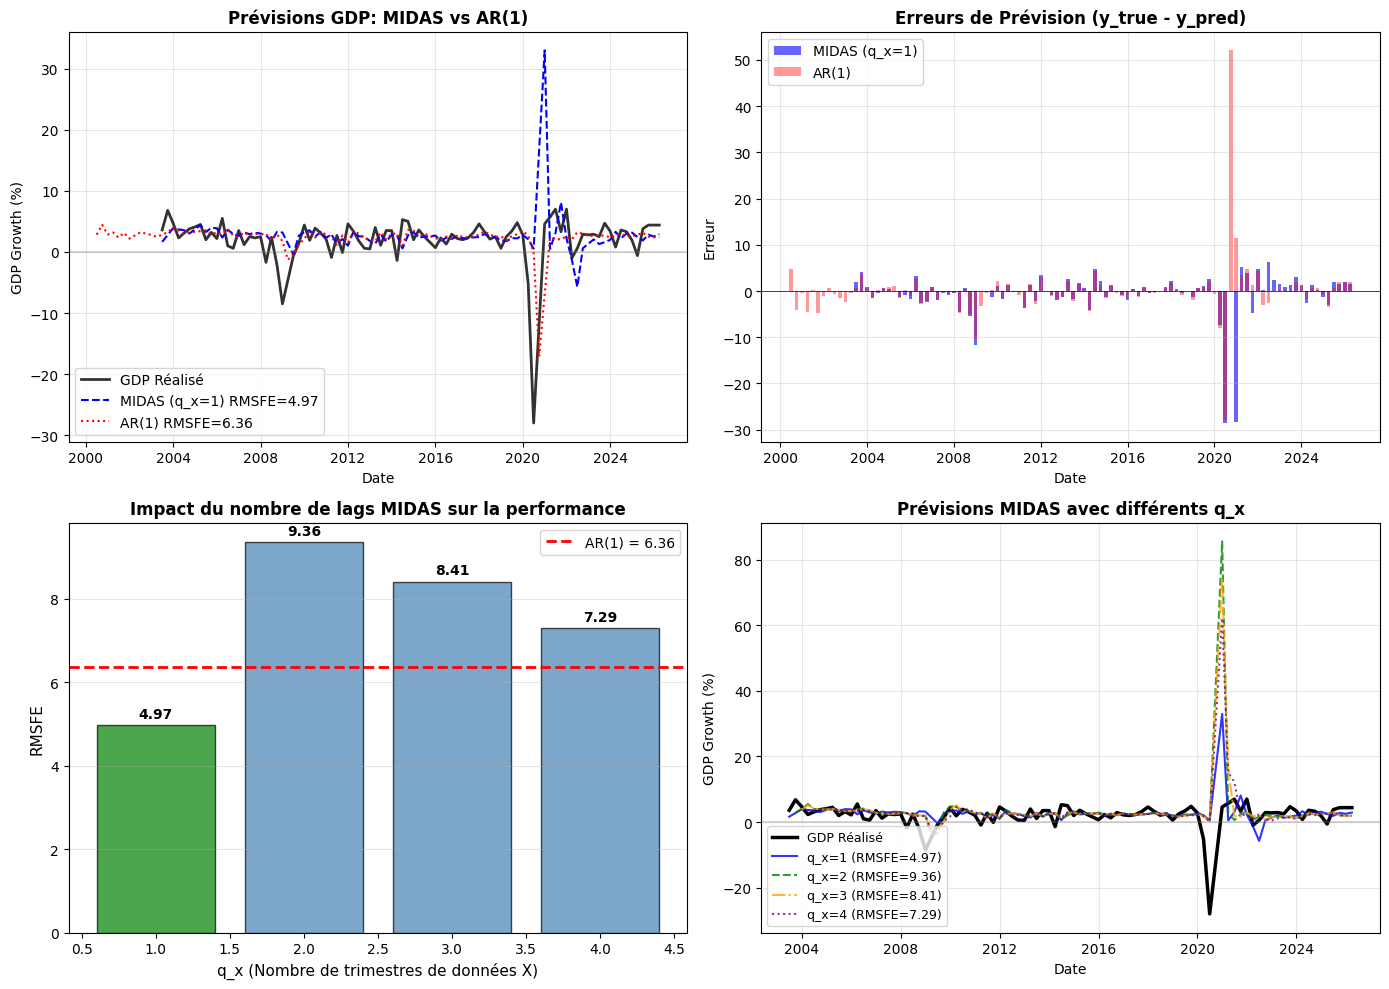


✓ Graphiques sauvegardés dans 'midas_comparison_plots.png'


In [25]:
# =============================================================================
# GRAPHIQUE 1: Prévisions vs Réalisations (Comparaison modèles)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: Prévisions MIDAS (DF5, q_x=1) vs AR(1) vs Réalisations ---
ax1 = axes[0, 0]
fc_midas = results_by_qx[1]
ax1.plot(fc_midas["target_date"], fc_midas["y_true"], 'k-', linewidth=2, label='GDP Réalisé', alpha=0.8)
ax1.plot(fc_midas["target_date"], fc_midas["y_pred"], 'b--', linewidth=1.5, label=f'MIDAS (q_x=1) RMSFE={rmsfe(fc_midas):.2f}')
ax1.plot(fc_ar1["target_date"], fc_ar1["y_pred"], 'r:', linewidth=1.5, label=f'AR(1) RMSFE={rmsfe_ar1:.2f}')
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.set_title('Prévisions GDP: MIDAS vs AR(1)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP Growth (%)')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

# --- Plot 2: Erreurs de prévision MIDAS vs AR(1) ---
ax2 = axes[0, 1]
ax2.bar(fc_midas["target_date"], fc_midas["fe"], alpha=0.6, label=f'MIDAS (q_x=1)', color='blue', width=60)
ax2.bar(fc_ar1["target_date"], fc_ar1["fe"], alpha=0.4, label=f'AR(1)', color='red', width=60)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Erreurs de Prévision (y_true - y_pred)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Erreur')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Plot 3: Comparaison RMSFE par q_x ---
ax3 = axes[1, 0]
qx_labels = list(results_by_qx.keys())
rmsfe_values = [rmsfe(results_by_qx[q]) for q in qx_labels]
colors = ['green' if r == min(rmsfe_values) else 'steelblue' for r in rmsfe_values]
bars = ax3.bar(qx_labels, rmsfe_values, color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=rmsfe_ar1, color='red', linestyle='--', linewidth=2, label=f'AR(1) = {rmsfe_ar1:.2f}')
ax3.set_xlabel('q_x (Nombre de trimestres de données X)', fontsize=11)
ax3.set_ylabel('RMSFE', fontsize=11)
ax3.set_title('Impact du nombre de lags MIDAS sur la performance', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, rmsfe_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Plot 4: Évolution des prévisions avec différents q_x ---
ax4 = axes[1, 1]
ax4.plot(results_by_qx[1]["target_date"], results_by_qx[1]["y_true"], 'k-', linewidth=2.5, label='GDP Réalisé')
linestyles = ['-', '--', '-.', ':']
colors_qx = ['blue', 'green', 'orange', 'purple']
for i, q_x in enumerate(q_x_values):
    if q_x in results_by_qx:
        fc_q = results_by_qx[q_x]
        ax4.plot(fc_q["target_date"], fc_q["y_pred"], linestyle=linestyles[i], 
                 color=colors_qx[i], linewidth=1.5, alpha=0.8,
                 label=f'q_x={q_x} (RMSFE={rmsfe(fc_q):.2f})')
ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax4.set_title('Prévisions MIDAS avec différents q_x', fontsize=12, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('GDP Growth (%)')
ax4.legend(loc='lower left', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('midas_comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Graphiques sauvegardés dans 'midas_comparison_plots.png'")

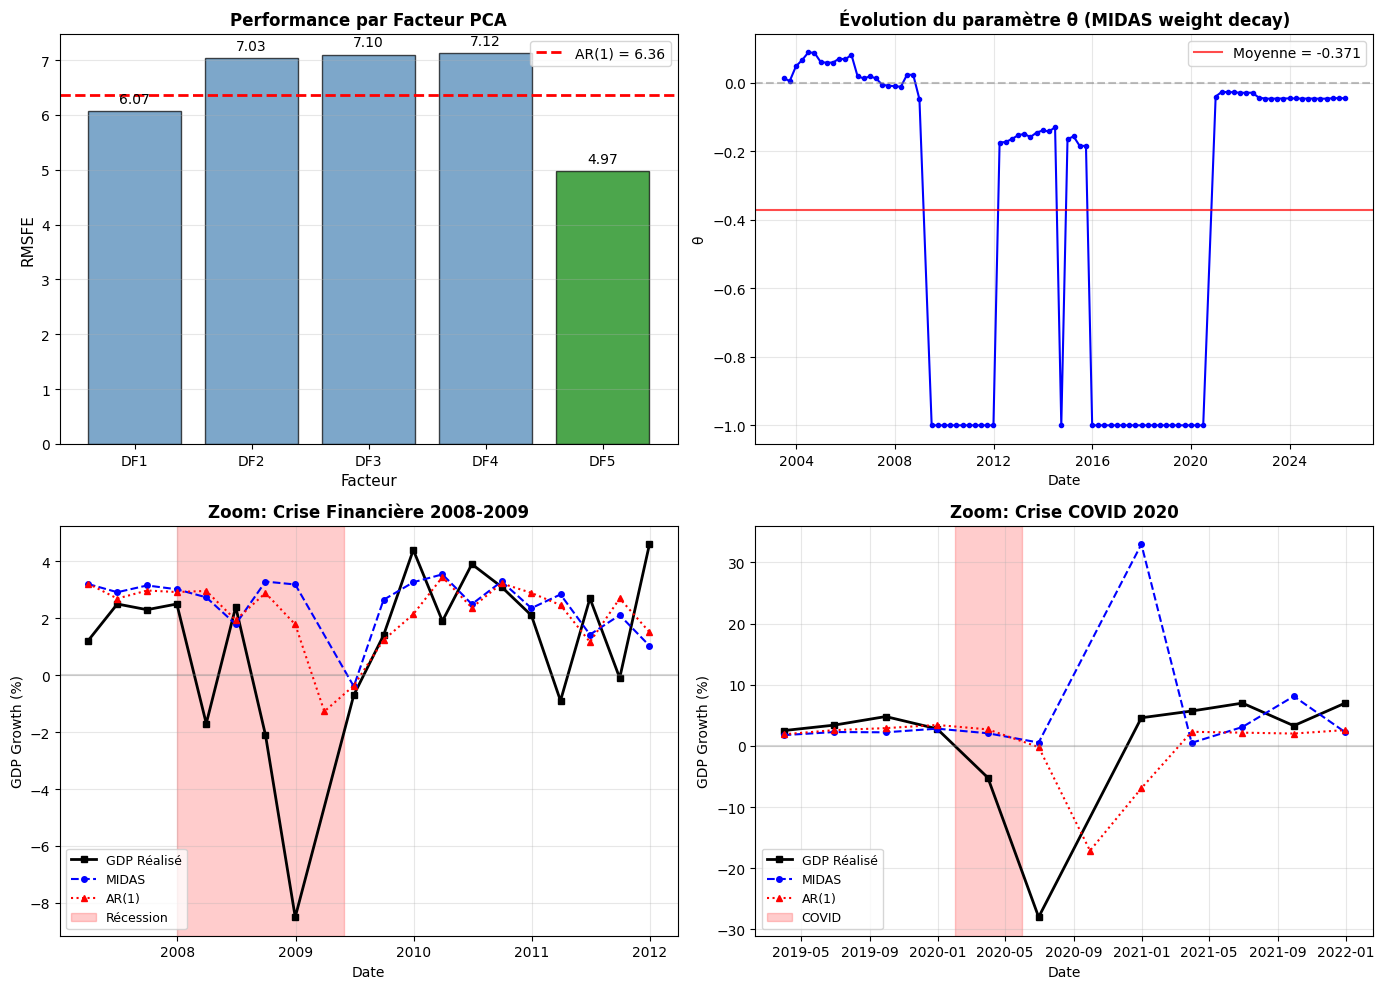


✓ Graphiques sauvegardés dans 'midas_analysis_detailed.png'


In [26]:
# =============================================================================
# GRAPHIQUE 2: Analyse détaillée par facteur et période
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: RMSFE par facteur ---
ax1 = axes[0, 0]
factor_names = list(factor_preds.keys())
factor_rmsfe = [rmsfe(recursive_forecast_adl_midas(yq, df_factors[f], spec, start_train_q=start_train, min_train_obs=20)) 
                for f in factor_names]
colors = ['green' if r == min(factor_rmsfe) else 'steelblue' for r in factor_rmsfe]
bars = ax1.bar(factor_names, factor_rmsfe, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=rmsfe_ar1, color='red', linestyle='--', linewidth=2, label=f'AR(1) = {rmsfe_ar1:.2f}')
ax1.set_xlabel('Facteur', fontsize=11)
ax1.set_ylabel('RMSFE', fontsize=11)
ax1.set_title('Performance par Facteur PCA', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, factor_rmsfe):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=10)

# --- Plot 2: Évolution du paramètre theta au cours du temps ---
ax2 = axes[0, 1]
fc_best = results_by_qx[1]  # MIDAS avec q_x=1
ax2.plot(fc_best["target_date"], fc_best["theta"], 'b-', linewidth=1.5, marker='o', markersize=3)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=fc_best["theta"].mean(), color='red', linestyle='-', alpha=0.7, 
            label=f'Moyenne = {fc_best["theta"].mean():.3f}')
ax2.set_title('Évolution du paramètre θ (MIDAS weight decay)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('θ')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Plot 3: Prévisions pendant les crises (zoom sur 2008-2010 et 2020) ---
ax3 = axes[1, 0]
# Période crise 2008
mask_crisis = (fc_best["target_date"] >= "2007-01-01") & (fc_best["target_date"] <= "2012-01-01")
fc_crisis = fc_best[mask_crisis]
fc_ar1_crisis = fc_ar1[(fc_ar1["target_date"] >= "2007-01-01") & (fc_ar1["target_date"] <= "2012-01-01")]

ax3.plot(fc_crisis["target_date"], fc_crisis["y_true"], 'k-', linewidth=2, label='GDP Réalisé', marker='s', markersize=4)
ax3.plot(fc_crisis["target_date"], fc_crisis["y_pred"], 'b--', linewidth=1.5, label='MIDAS', marker='o', markersize=4)
ax3.plot(fc_ar1_crisis["target_date"], fc_ar1_crisis["y_pred"], 'r:', linewidth=1.5, label='AR(1)', marker='^', markersize=4)
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax3.axvspan(pd.Timestamp("2008-01-01"), pd.Timestamp("2009-06-01"), alpha=0.2, color='red', label='Récession')
ax3.set_title('Zoom: Crise Financière 2008-2009', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('GDP Growth (%)')
ax3.legend(loc='lower left', fontsize=9)
ax3.grid(True, alpha=0.3)

# --- Plot 4: Prévisions pendant COVID (zoom sur 2019-2022) ---
ax4 = axes[1, 1]
mask_covid = (fc_best["target_date"] >= "2019-01-01") & (fc_best["target_date"] <= "2022-01-01")
fc_covid = fc_best[mask_covid]
fc_ar1_covid = fc_ar1[(fc_ar1["target_date"] >= "2019-01-01") & (fc_ar1["target_date"] <= "2022-01-01")]

if len(fc_covid) > 0:
    ax4.plot(fc_covid["target_date"], fc_covid["y_true"], 'k-', linewidth=2, label='GDP Réalisé', marker='s', markersize=4)
    ax4.plot(fc_covid["target_date"], fc_covid["y_pred"], 'b--', linewidth=1.5, label='MIDAS', marker='o', markersize=4)
    if len(fc_ar1_covid) > 0:
        ax4.plot(fc_ar1_covid["target_date"], fc_ar1_covid["y_pred"], 'r:', linewidth=1.5, label='AR(1)', marker='^', markersize=4)
    ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax4.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-06-01"), alpha=0.2, color='red', label='COVID')
    ax4.set_title('Zoom: Crise COVID 2020', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('GDP Growth (%)')
    ax4.legend(loc='lower left', fontsize=9)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Pas de données COVID disponibles', ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.savefig('midas_analysis_detailed.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Graphiques sauvegardés dans 'midas_analysis_detailed.png'")

In [27]:
# =============================================================================
# TABLEAU RÉCAPITULATIF DES PERFORMANCES
# =============================================================================

# Calculer les métriques pour tous les modèles
summary_data = []

# AR(1) benchmark
summary_data.append({
    "Modèle": "AR(1) Benchmark",
    "RMSFE": rmsfe_ar1,
    "MAE": np.abs(fc_ar1["fe"]).mean(),
    "n_forecasts": len(fc_ar1),
    "Gain vs AR(1) (%)": 0.0
})

# MIDAS par facteur (q_x=1)
for f in factor_names:
    fc_f = recursive_forecast_adl_midas(yq, df_factors[f], spec, start_train_q=start_train, min_train_obs=20)
    if len(fc_f) > 0:
        r = rmsfe(fc_f)
        summary_data.append({
            "Modèle": f"MIDAS {f} (q_x=1)",
            "RMSFE": r,
            "MAE": np.abs(fc_f["fe"]).mean(),
            "n_forecasts": len(fc_f),
            "Gain vs AR(1) (%)": (rmsfe_ar1 - r) / rmsfe_ar1 * 100
        })

# MIDAS avec différents q_x (meilleur facteur DF5)
for q_x in q_x_values:
    if q_x in results_by_qx:
        fc_q = results_by_qx[q_x]
        r = rmsfe(fc_q)
        summary_data.append({
            "Modèle": f"MIDAS DF5 (q_x={q_x})",
            "RMSFE": r,
            "MAE": np.abs(fc_q["fe"]).mean(),
            "n_forecasts": len(fc_q),
            "Gain vs AR(1) (%)": (rmsfe_ar1 - r) / rmsfe_ar1 * 100
        })

# Combinaison
summary_data.append({
    "Modèle": "Combinaison MSFE",
    "RMSFE": rmsfe_comb,
    "MAE": np.nan,
    "n_forecasts": len(fc_df),
    "Gain vs AR(1) (%)": (rmsfe_ar1 - rmsfe_comb) / rmsfe_ar1 * 100
})

df_summary = pd.DataFrame(summary_data).sort_values("RMSFE")
df_summary["RMSFE"] = df_summary["RMSFE"].round(4)
df_summary["MAE"] = df_summary["MAE"].round(4)
df_summary["Gain vs AR(1) (%)"] = df_summary["Gain vs AR(1) (%)"].round(2)

print("=" * 80)
print("TABLEAU RÉCAPITULATIF - COMPARAISON DES MODÈLES")
print("=" * 80)
display(df_summary)

# Meilleur modèle
best_model = df_summary.iloc[0]
print(f"\n✓ Meilleur modèle: {best_model['Modèle']}")
print(f"  → RMSFE = {best_model['RMSFE']:.4f}")
print(f"  → Gain vs AR(1) = {best_model['Gain vs AR(1) (%)']:.2f}%")

TABLEAU RÉCAPITULATIF - COMPARAISON DES MODÈLES


,Modèle,RMSFE,MAE,n_forecasts,Gain vs AR(1) (%)
5,MIDAS DF5 (q_x=1),4.9744,2.4528,90,21.75
6,MIDAS DF5 (q_x=1),4.9744,2.4528,90,21.75
1,MIDAS DF1 (q_x=1),6.0718,2.6556,90,4.48
10,Combinaison MSFE,6.0843,NaN,92,4.29
0,AR(1) Benchmark,6.3567,2.5493,104,0.00
2,MIDAS DF2 (q_x=1),7.0301,2.9380,92,-10.59
3,MIDAS DF3 (q_x=1),7.0973,2.9722,92,-11.65
4,MIDAS DF4 (q_x=1),7.1233,2.8325,92,-12.06
9,MIDAS DF5 (q_x=4),7.2929,2.7627,88,-14.73
8,MIDAS DF5 (q_x=3),8.4134,2.8871,89,-32.36



✓ Meilleur modèle: MIDAS DF5 (q_x=1)
  → RMSFE = 4.9744
  → Gain vs AR(1) = 21.75%


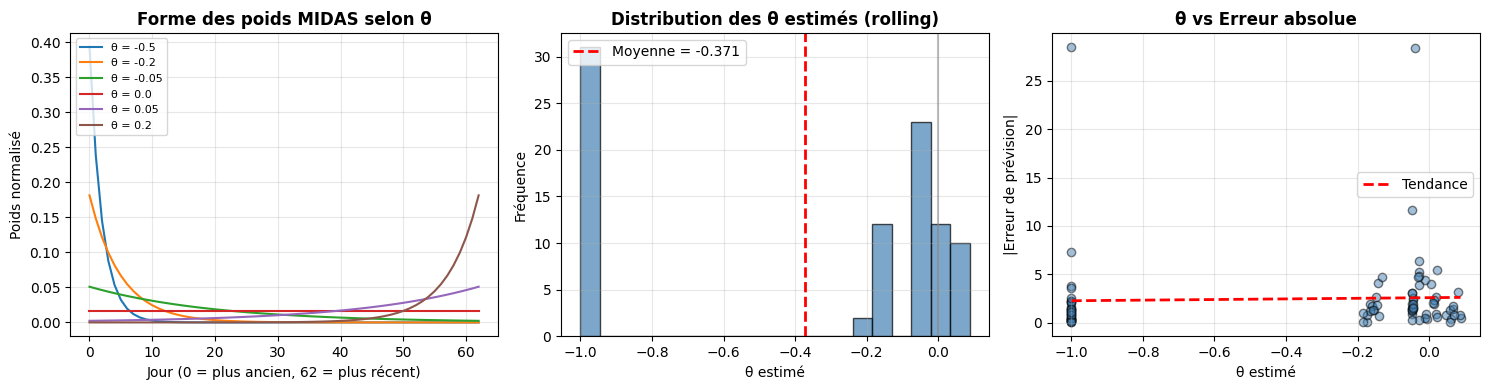


✓ Graphiques sauvegardés dans 'midas_weights_analysis.png'


In [28]:
# =============================================================================
# GRAPHIQUE 3: Poids MIDAS et interprétation
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- Plot 1: Forme des poids MIDAS pour différentes valeurs de theta ---
ax1 = axes[0]
m = 63  # jours par trimestre
thetas = [-0.5, -0.2, -0.05, 0.0, 0.05, 0.2]
for theta in thetas:
    w = exp_almon_weights(m, theta)
    ax1.plot(range(m), w, label=f'θ = {theta}', linewidth=1.5)
ax1.set_xlabel('Jour (0 = plus ancien, 62 = plus récent)', fontsize=10)
ax1.set_ylabel('Poids normalisé', fontsize=10)
ax1.set_title('Forme des poids MIDAS selon θ', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Plot 2: Distribution des theta estimés ---
ax2 = axes[1]
all_thetas = fc_best["theta"].values
ax2.hist(all_thetas, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=all_thetas.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne = {all_thetas.mean():.3f}')
ax2.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
ax2.set_xlabel('θ estimé', fontsize=10)
ax2.set_ylabel('Fréquence', fontsize=10)
ax2.set_title('Distribution des θ estimés (rolling)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Plot 3: Relation theta vs erreur de prévision ---
ax3 = axes[2]
ax3.scatter(fc_best["theta"], np.abs(fc_best["fe"]), alpha=0.5, c='steelblue', edgecolor='black')
# Ligne de tendance
z = np.polyfit(fc_best["theta"], np.abs(fc_best["fe"]), 1)
p = np.poly1d(z)
theta_range = np.linspace(fc_best["theta"].min(), fc_best["theta"].max(), 100)
ax3.plot(theta_range, p(theta_range), 'r--', linewidth=2, label='Tendance')
ax3.set_xlabel('θ estimé', fontsize=10)
ax3.set_ylabel('|Erreur de prévision|', fontsize=10)
ax3.set_title('θ vs Erreur absolue', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('midas_weights_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Graphiques sauvegardés dans 'midas_weights_analysis.png'")